# IMAGE CAPTION GENERATOR
- Generating Caption for Images

## Steps
- Data collection
- Understanding the data
- Data Cleaning
- Loading the trained set
- Data Preprocessing -- Images
- Data Preprocessing -- Captions
- Data preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
import tensorflow as tf
from time import time
import pickle
from pickle import dump,load
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from tensorflow import keras,lite
from nltk.translate.bleu_score import corpus_bleu

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [4]:
captions[1]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .'

In [5]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [6]:
print(len(captions))

40460


In [7]:
 #Dictionary to map each Image with the list of captions it has

In [8]:
demo_first, demo_second = captions[1].split('\t')
print(demo_first.split(".")[0])
print(demo_second)

1000268201_693b08cb0e
A girl going into a wooden building .


In [9]:
descriptions={}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split('.')[0]
    
    #if image id already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)        

In [10]:
descriptions["1000268201_693b08cb0e"] #get the list of captions from descriptions dictionary

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
len(descriptions)

8092

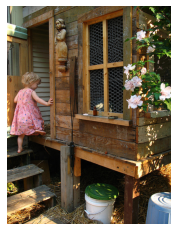

In [12]:
import cv2
img= cv2.imread('./Data/Images/1000268201_693b08cb0e.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## DATA CLEANING

In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ", sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    
    
    

In [14]:
clean_text("He is purchasing food from shop #23")

'he is purchasing food from shop'

In [15]:
# clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [16]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
# Write the data in the text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

## VOCABULARY

In [18]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions = f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)


In [19]:
print(descriptions)

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin'], '1001773457_577c3a7d70': ['black dog and spotted dog are fighting', 'black dog and tri colored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other'], '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'little girl is sitting in front of large painted rainbow', 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it', 'there is girl with pigtails sitting in front of rainbow painting', 'young girl with pigtails painting outside i

In [20]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab size: %d" %len(vocab))

Vocab size: 8424


In [21]:
#total no. of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("total words %d" %len(total_words))

total words 373837


In [22]:
import collections

counter = collections.Counter(total_words)
freq_cnt=dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [23]:
#sort this dictionary according to freq count
sorted_freq_cnt= sorted(freq_cnt.items(),reverse= True,key=lambda x:x[1])

#filter
threshold=10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [24]:
sorted_freq_cnt

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [25]:
total_words

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

In [26]:
total_words[0]

'in'

In [27]:
print(len(total_words)) # had abt 4 lakh+ words.. narrowed down to 8K+ unique and finally found 1K+ words that are most frequently used unique words

1845


In [28]:
with open("vocab.txt","w") as f:
    f.write(str(total_words))

## Prepare Train/ Test Data

In [29]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [30]:
train_for_encoding=[row for row in train_file_data.split("\n")[:-1]]
print(len(train_for_encoding))  #extract all the image ids in train_file 

6000


In [31]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(len(train))  #extract all the image ids in train_file 

6000


In [32]:
test_for_encoding = [row for row in test_file_data.split("\n")[:-1]]
print(len(test_for_encoding))

1000


In [33]:
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(len(test))

1000


In [34]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [35]:
train_for_encoding[:5]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg']

In [36]:
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)
     

In [37]:
test_descriptions = {}
for img_id in test:
    test_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        test_descriptions[img_id].append(cap_to_append)

In [38]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## TRANSFER LEARNING
- images
- text

In [50]:
model= ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [51]:
model_new = Model(model.input,model.layers[-2].output)
model_new.save('Resnet.h5')

In [40]:
model = tf.keras.models.load_model('Resnet.h5') 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS]
tfmodel = converter.convert()
open('resnet50_new.tflite','wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\hkaug\AppData\Local\Temp\tmpbs0aev74\assets


93963440

In [52]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    return img
    

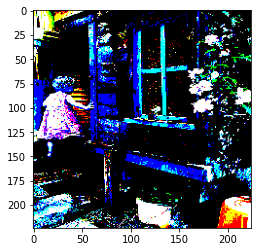

In [53]:
img = preprocess_img('./Data/Images/1000268201_693b08cb0e.jpg')
plt.imshow(img[0])
plt.show()

In [54]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector 
#yeh h jo image aaegi uspr lgega

In [55]:
x=encode_img('./Data/Images/1000268201_693b08cb0e.jpg')
print(len(x))
print(x)
print(type(x[20]))
with open("picture.txt","w") as f:
    for element in x:
        f.write(str(str(element)+"F, "))


2048
[0.0653655  0.16782689 0.3251846  ... 0.0511154  0.32817933 1.0043331 ]
<class 'numpy.float32'>


In [98]:
start_t= time()
encoding_train={}

for ix,img_id in enumerate(train_for_encoding):
    img_path="./Data/Images/"+img_id
    #print(img_id)
    encoding_train[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in progess.. step %d"%ix)
    
end_t = time()
print("Total time : %d" %(end_t-start_t))

Encoding in progess.. step 0
Encoding in progess.. step 100
Encoding in progess.. step 200
Encoding in progess.. step 300
Encoding in progess.. step 400
Encoding in progess.. step 500
Encoding in progess.. step 600
Encoding in progess.. step 700
Encoding in progess.. step 800
Encoding in progess.. step 900
Encoding in progess.. step 1000
Encoding in progess.. step 1100
Encoding in progess.. step 1200
Encoding in progess.. step 1300
Encoding in progess.. step 1400
Encoding in progess.. step 1500
Encoding in progess.. step 1600
Encoding in progess.. step 1700
Encoding in progess.. step 1800
Encoding in progess.. step 1900
Encoding in progess.. step 2000
Encoding in progess.. step 2100
Encoding in progess.. step 2200
Encoding in progess.. step 2300
Encoding in progess.. step 2400
Encoding in progess.. step 2500
Encoding in progess.. step 2600
Encoding in progess.. step 2700
Encoding in progess.. step 2800
Encoding in progess.. step 2900
Encoding in progess.. step 3000
Encoding in progess.

In [99]:
#store evrything to disk
with open("encoded_train_features.pkl","wb")as f:
    pickle.dump(encoding_train,f)

In [480]:
start_t= time()
encoding_test={}
for ix,img_id in enumerate(test_for_encoding):
    img_path="./Data/Images/"+img_id
    #print(img_id)
    encoding_test[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print("Encoding test image in progess.. step %d"%ix)
    
end_t = time()
print("Total time : %d" %(end_t-start_t))

Encoding test image in progess.. step 0
Encoding test image in progess.. step 100
Encoding test image in progess.. step 200
Encoding test image in progess.. step 300
Encoding test image in progess.. step 400
Encoding test image in progess.. step 500
Encoding test image in progess.. step 600
Encoding test image in progess.. step 700
Encoding test image in progess.. step 800
Encoding test image in progess.. step 900
Total time : 467


In [482]:
print(encoding_test)

{'3385593926_d3e9c21170.jpg': array([0.3331689 , 0.38347757, 0.0725344 , ..., 0.9083214 , 0.35600552,
       1.0914081 ], dtype=float32), '2677656448_6b7e7702af.jpg': array([0.29455978, 0.09500366, 0.7013552 , ..., 0.01996762, 0.2911187 ,
       0.10959285], dtype=float32), '311146855_0b65fdb169.jpg': array([0.01133586, 0.08780409, 0.14325376, ..., 0.03005862, 1.1857141 ,
       0.06954609], dtype=float32), '1258913059_07c613f7ff.jpg': array([0.04770466, 1.4354503 , 0.10770211, ..., 0.13344458, 0.11505579,
       2.049624  ], dtype=float32), '241347760_d44c8d3a01.jpg': array([0.06552811, 6.6828294 , 0.31763437, ..., 0.06200404, 0.03742842,
       0.04522504], dtype=float32), '2654514044_a70a6e2c21.jpg': array([1.956204  , 0.04316799, 0.1114384 , ..., 0.02008313, 0.68325484,
       0.43294132], dtype=float32), '2339106348_2df90aa6a9.jpg': array([0.08876347, 1.1927911 , 0.07676528, ..., 0.01899937, 0.13417557,
       0.13799469], dtype=float32), '256085101_2c2617c5d0.jpg': array([0.61918

In [483]:
with open("encoded_test_features.pkl","wb")as f:
    pickle.dump(encoding_test,f)

In [56]:
train_features=load(open("./encoded_train_features.pkl","rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [57]:
test_features=load(open("./encoded_test_features.pkl","rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


### Data Pre-Processing for captions

In [58]:
len(total_words)
#print(total_words[0])

1845

In [59]:
word_2_indx={}
indx_2_word={}
for i, word in enumerate(total_words):
    word_2_indx[word]= i+1
    indx_2_word[i+1]= word 


In [60]:
word_2_indx['startseq']=1846
indx_2_word[1846]='startseq'
word_2_indx['endseq']=1847
indx_2_word[1847]='endseq'
print(indx_2_word[1])

in


In [61]:
print("Vocab size: ")
print((len(word_2_indx)+1))


Vocab size: 
1848


In [62]:
max_len=0
for key in descriptions.keys():
    for cap in descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print("Max len : %d"%max_len)

Max len : 33


### data loader (Generator)

In [63]:
train_features.keys()

dict_keys(['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg', '218342358_1755a9cce1.jpg', '2501968935_02f2cd8079.jpg', '2699342860_5288e203ea.jpg', '2638369467_8fc251595b.jpg', '2926786902_815a99a154.jpg', '2851304910_b5721199bc.jpg', '3423802527_94bd2b23b0.jpg', '3356369156_074750c6cc.jpg', '2294598473_40637b5c04.jpg', '1191338263_a4fa073154.jpg', '2380765956_6313d8cae3.jpg', '3197891333_b1b0fd1702.jpg', '3119887967_271a097464.jpg', '2276499757_b44dc6f8ce.jpg', '2506892928_7e79bec613.jpg', '2187222896_c206d63396.jpg', '2826769554_85c90864c9.jpg', '3097196395_ec06075389.jpg', '3603116579_4a28a932e2.jpg', '3339263085_6db9fd0981.jpg', '2532262109_87429a2cae.jpg', '2076906555_c20dc082db.jpg', '2502007071_82a8c639cf.jpg', '3113769557_9edbb8275c.jpg', '3325974730_3ee192e4ff.jpg', '1655781989_b15ab4cbff.jpg', '1662261486_db967930de.jpg', '2410562803_56ec09f41c.jpg', '2469498117_b4543e1460.jpg', '6971

In [64]:
def data_generator(train_descriptions, photos, word_2_indx, max_len, batch_size):
    X1,X2, y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = photos[key+'.jpg']
            ##print(type(photo))
            for desc in desc_list:
                seq = [word_2_indx[word] for word in desc.split() if word in word_2_indx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n == batch_size:
                    yield[[np.array(X1), np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n=0

In [65]:
vocab_size=(len(word_2_indx)+1)
print(word_2_indx)

{'in': 1, 'the': 2, 'on': 3, 'is': 4, 'and': 5, 'dog': 6, 'with': 7, 'man': 8, 'of': 9, 'two': 10, 'white': 11, 'black': 12, 'boy': 13, 'are': 14, 'woman': 15, 'girl': 16, 'to': 17, 'wearing': 18, 'at': 19, 'people': 20, 'water': 21, 'red': 22, 'young': 23, 'brown': 24, 'an': 25, 'his': 26, 'blue': 27, 'dogs': 28, 'running': 29, 'through': 30, 'playing': 31, 'while': 32, 'shirt': 33, 'down': 34, 'standing': 35, 'ball': 36, 'little': 37, 'grass': 38, 'snow': 39, 'child': 40, 'person': 41, 'jumping': 42, 'over': 43, 'three': 44, 'front': 45, 'sitting': 46, 'holding': 47, 'up': 48, 'field': 49, 'small': 50, 'by': 51, 'large': 52, 'green': 53, 'one': 54, 'group': 55, 'yellow': 56, 'her': 57, 'walking': 58, 'children': 59, 'men': 60, 'into': 61, 'air': 62, 'beach': 63, 'near': 64, 'mouth': 65, 'jumps': 66, 'another': 67, 'for': 68, 'street': 69, 'runs': 70, 'its': 71, 'from': 72, 'riding': 73, 'stands': 74, 'as': 75, 'bike': 76, 'girls': 77, 'outside': 78, 'other': 79, 'off': 80, 'out': 81,

In [66]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [67]:
embedding_index={}

for line in f:
    values = line.split()
    word = values[0]
    #print(word)
    word_embedding =np.array(values[1:51], dtype='float')
    embedding_index[word]= word_embedding



In [68]:
f.close()

In [69]:
print(embedding_index['we'])

[ 0.57387  -0.32729   0.070521 -0.4198    0.862    -0.80001  -0.40604
  0.15312  -0.29788  -0.1105   -0.097119  0.59642  -0.99814  -0.28148
  1.0152    0.87544   1.0282   -0.05036   0.24194  -1.1426   -0.50601
  0.64976   0.74833   0.020473  0.9595   -1.9204   -0.80656   0.29247
  1.0009   -0.98565   4.0094    1.0407   -0.82849  -0.4847   -0.36146
 -0.39552   0.27891   0.15312   0.15848   0.018686 -0.50905  -0.22916
  0.1868    0.44946   0.10229   0.21882  -0.30608   0.48759  -0.18439
  0.69939 ]


In [70]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word, indx in word_2_indx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[indx] = embedding_vector
    return matrix
        
    
    

In [71]:
embedding_matrix=(get_embedding_matrix())
embedding_matrix.shape
# print(embedding_matrix[56])
# print(indx_2_word[56])

(1848, 50)

## Model architecture

In [72]:
input_img_features= Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [73]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True )(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [74]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256, activation='relu')(decoder1)
outputs=Dense(vocab_size, activation='softmax')(decoder2)

#combined model
model = Model(inputs= [input_img_features, input_captions], outputs=outputs)

In [75]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 50)       92400       ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

In [76]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [77]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## Training of Model

In [79]:
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch


In [80]:
print(train_features)

{'2513260012_03d33305cf.jpg': array([0.34707946, 0.5115909 , 0.08728854, ..., 1.1897293 , 0.04043847,
       0.15271065], dtype=float32), '2903617548_d3e38d7f88.jpg': array([0.        , 0.00307796, 0.09360033, ..., 0.4310343 , 0.37985304,
       0.91657585], dtype=float32), '3338291921_fe7ae0c8f8.jpg': array([0.7674472 , 0.5342269 , 0.383252  , ..., 0.02098641, 0.18429385,
       0.04270015], dtype=float32), '488416045_1c6d903fe0.jpg': array([6.2481064e-01, 3.2965457e-01, 1.7821058e-04, ..., 1.2753810e+00,
       4.6392566e-01, 4.9036074e-01], dtype=float32), '2644326817_8f45080b87.jpg': array([0.11555312, 0.6596537 , 0.05323281, ..., 0.14397353, 1.0179377 ,
       0.00556584], dtype=float32), '218342358_1755a9cce1.jpg': array([1.7061832 , 0.40514728, 0.35206553, ..., 0.29408896, 0.04833034,
       0.04654434], dtype=float32), '2501968935_02f2cd8079.jpg': array([0.10608295, 1.4420797 , 0.04447002, ..., 0.20587182, 0.6978754 ,
       1.590432  ], dtype=float32), '2699342860_5288e203ea.j

In [475]:
for i in range(epochs):
    generator = data_generator(train_descriptions,train_features,word_2_indx,max_len,number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

<ipython-input-475-7ffc4512520b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 1202s 601ms/step - loss: 2.4658


In [81]:
model.load_weights('./model_weights/model_19.h5')

In [68]:
model = tf.keras.models.load_model('./model_weights/model_19.h5') 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS]
tfmodel = converter.convert()
open('tf_model_2.tflite','wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\hkaug\AppData\Local\Temp\tmpov2v_db8\assets


INFO:tensorflow:Assets written to: C:\Users\hkaug\AppData\Local\Temp\tmpov2v_db8\assets


7160688

## Predictions

In [82]:
images = './Data/Images/'

In [83]:
with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [84]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_2_indx[w] for w in in_text.split() if w in word_2_indx]
        sequence = pad_sequences([sequence], maxlen=max_len,padding='post')
        yhat = model.predict([photo,sequence])
        yhat = yhat.argmax()
        word = indx_2_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [85]:
def evaluate_model(model, descriptions, photos, max_length):
    actual, predicted = list(), list()
	# step over the whole set
    i=0
    for key, desc_list in descriptions.items():
		# generate description
        yhat = greedySearch(photos[key+'.jpg'].reshape(1,2048))
		# store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        i+=1
        if i%100==0:
            print("Working at step! %d"%i)
	# calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [172]:
evaluate_model(model, test_descriptions, test_features, max_len)

Working at step! 100
Working at step! 200
Working at step! 300
Working at step! 400
Working at step! 500
Working at step! 600
Working at step! 700
Working at step! 800
Working at step! 900
Working at step! 1000
BLEU-1: 0.418759
BLEU-2: 0.240316
BLEU-3: 0.167765
BLEU-4: 0.076072


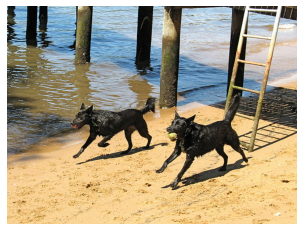

PREDICTED CAPTION: black and white dog is running through the water
REFERENCES:
   two black dogs each with running on the beach with balls in their mouths
   two black dogs run in the sand by pier
   two black dogs run through sand
   two dogs run across the sand near boardwalk
   two wet black dogs are running through some sand
BLEU-1: 0.444444
BLEU-2: 0.235702
BLEU-3: 0.000000
BLEU-4: 0.000000
*****************************************************************************


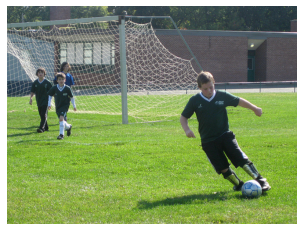

PREDICTED CAPTION: soccer player in blue and white uniform is kicking the ball
REFERENCES:
   boy in green uniform is kicking soccer ball in game while two others stand behind him
   boys play soccer near goal post
   some children are playing soccer on sports field by the goal
   the little boy gets ready to kick the soccer ball
   three boys play soccer
BLEU-1: 0.636364
BLEU-2: 0.356753
BLEU-3: 0.278707
BLEU-4: 0.000000
*****************************************************************************


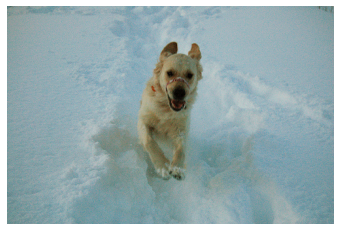

PREDICTED CAPTION: dog is running through the snow
REFERENCES:
   dog is playing in the deep snow
   dog running through deep snow pack
   dog runs through the deep snow
   white dog is running through the snow
   white dog running through snow
BLEU-1: 1.000000
BLEU-2: 1.000000
BLEU-3: 1.000000
BLEU-4: 1.000000
*****************************************************************************


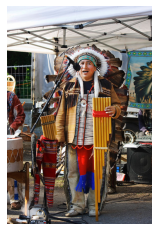

PREDICTED CAPTION: man in black shirt is playing violin
REFERENCES:
   man dressed as an indian speaking into microphone
   native american stands at microphone ready to play his instrument
   an indian chief in full dress
   indian wearing headgear speaks
   the man dressed liked an indian wearing feathers is standing in front of the microphone
BLEU-1: 0.428571
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
*****************************************************************************


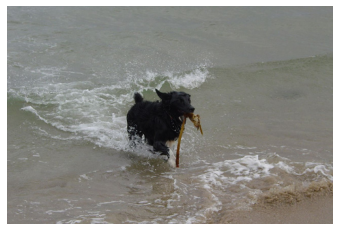

PREDICTED CAPTION: black dog is running through the water
REFERENCES:
   black dog carrying an object out of the water
   black dog carrying some seaweed out of the water
   black dog is coming out of the ocean water on the beach with something in its mouth
   black dog with stick in its mouth is walking out of the water onto beach
   dog retrieves branch from on beach
BLEU-1: 0.714286
BLEU-2: 0.597614
BLEU-3: 0.453066
BLEU-4: 0.000000
*****************************************************************************


In [101]:
for x in range(5):
    actual, predicted = list(), list()
    idx=np.random.randint(0,1000)
    all_img_name = list(encoding_test.keys())
    img_name=all_img_name[idx]
    img_id=img_name.split('.')[0]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    predicted_caption = greedySearch(photo_2048)
    i=plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show(descriptions[img_id])
    print('PREDICTED CAPTION: '+ predicted_caption)
    print('REFERENCES:')
    for d in descriptions[img_id]:
        print('   '+d)
    references = [d.split() for d in descriptions[img_id]]
    actual.append(references)
    predicted.append(predicted_caption.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    print('*****************************************************************************')

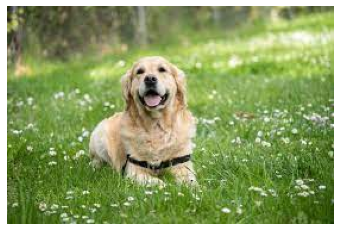

[[2.1672740e+00 1.3631901e-01 3.9460592e-02 ... 1.7305024e-01
  2.2742116e-01 1.2024641e-03]]


dog is running through the grass


In [186]:
img= cv2.imread('C:/Users/hkaug/Downloads/hars/dog456.jfif')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
input_image = encode_img('C:/Users/hkaug/Downloads/hars/dog456.jfif')
photo_2048 = input_image.reshape((1,2048))
print(photo_2048)
caption = greedySearch(photo_2048)
print("\n")
print(caption)

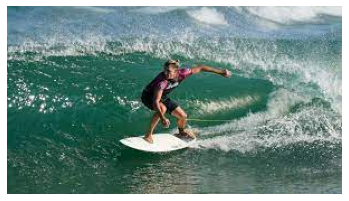

[[0.48450214 0.662586   0.82626134 ... 0.48129642 0.02594738 0.47546703]]


surfer in wetsuit riding wave


In [187]:
img= cv2.imread('C:/Users/hkaug/Downloads/hars/surfer123.jfif')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
input_image = encode_img('C:/Users/hkaug/Downloads/hars/surfer123.jfif')
photo_2048 = input_image.reshape((1,2048))
print(photo_2048)
caption = greedySearch(photo_2048)
print("\n")
print(caption)

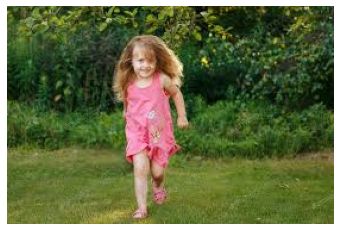

[[0.4269115  0.5106612  0.02956044 ... 0.8332014  1.347995   0.08475948]]


little girl in denim dress walks in the grass


In [188]:
img= cv2.imread('C:/Users/hkaug/Downloads/hars/girl456.jfif')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
input_image = encode_img('C:/Users/hkaug/Downloads/hars/girl456.jfif')
photo_2048 = input_image.reshape((1,2048))
print(photo_2048)
caption = greedySearch(photo_2048)
print("\n")
print(caption)